## Description

Paper: Kendall & Gal: "What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?" (2017)[link](https://arxiv.org/abs/1703.04977)

Note: for 1 dimensional regression the only viable XAI methods would be to identify influential examples

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Regression

**Loss Function**

$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^N\frac{1}{2\sigma(x_i)^2}\|y_i - f(x_i)\|^2 + \frac{1}{2}\log\sigma(x_i)^2
$$

For reasons of stability the network output is the log varaince $s_i = \log\sigma(x_i)^2$. 

In [2]:
############################################
# Network
############################################

class RegressionNetwork(nn.Module):
    def __init__(self):
        super(RegressionNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Increased hidden layer size
        self.fc1h = nn.Linear(64, 64)
        self.fc2_mean = nn.Linear(64, 1)
        self.fc2_var = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1h(torch.tanh(self.fc1(x))))
        mean = self.fc2_mean(x)
        log_var = self.fc2_var(x)  # Predict the log variance
        return mean, log_var

############################################
# Loss function
############################################

def loss_function(x_mean, x_log_var, y):
    x_mean = x_mean.squeeze()
    x_log_var = x_log_var.squeeze()

    batch_loss = 0.5 * torch.exp(-x_log_var)*((y-x_mean)**2)+0.5*x_log_var
    return batch_loss.mean()


##########################################
# Training loop
############################################

def train(model, data_x, data_y, n_epochs, verbose=False):

    model = RegressionNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()
        mean, log_var = model(X)

        loss = loss_function(mean, log_var, y)

        if verbose & (epoch%100 == 0):
            print(f"Train Loss {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    return model

### Mean Dependent Variance

Generate a dataset where the variance changes as a function of the mean. Samplesize and variance strength can be adjusted. 

In [3]:
np.random.seed(0)

def make_mean_dependent_variance_data(n, variance_strength=0.5, x_min=0, x_max=5):
    '''
    Generate datapoints from a sinus function from x_min to x_max and add random 
    noise that is proportional to the amplitude of the function. 
    
    n .... number of samples to generate
    variance_strength ... factor by which to scale the variance
    x_min, x_max ... start and end of the functions x-values
    '''
    X = np.sort((x_max-x_min)*np.random.rand(n, 1) + x_min, axis=0)
    y = np.sin(X).ravel()

    var_y = (variance_strength*np.sin(X).ravel())**2
    y += np.random.normal(loc=0., scale=var_y, size=n)

    # Convert data to PyTorch tensors
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()

    return X, y

#### Examples of 1-d functions with mean-dependent variance

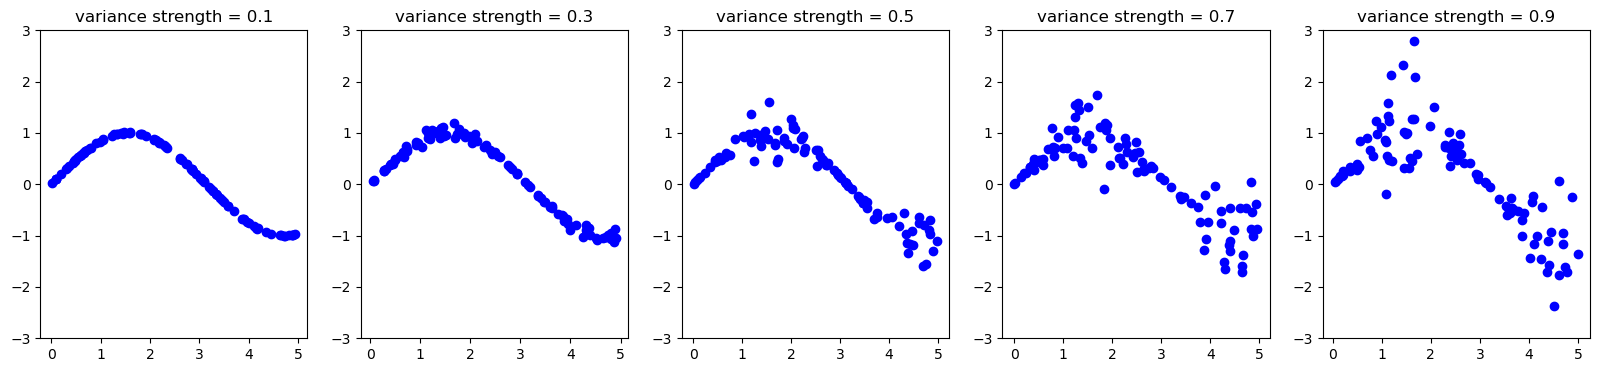

In [4]:
N = 100
VS = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(20, 4))
for idx, vs in enumerate(VS):
    X, y = make_mean_dependent_variance_data(N, variance_strength=vs)
    plt.subplot(1,len(VS), idx+1)
    plt.scatter(X, y, c='b', marker='o', label='Data')
    plt.ylim(-3, 3)
    plt.title(f"variance strength = {vs}")


#### Examples of network fit for different datasets

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 685.81it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 564.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.68it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.68it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.62it/s]


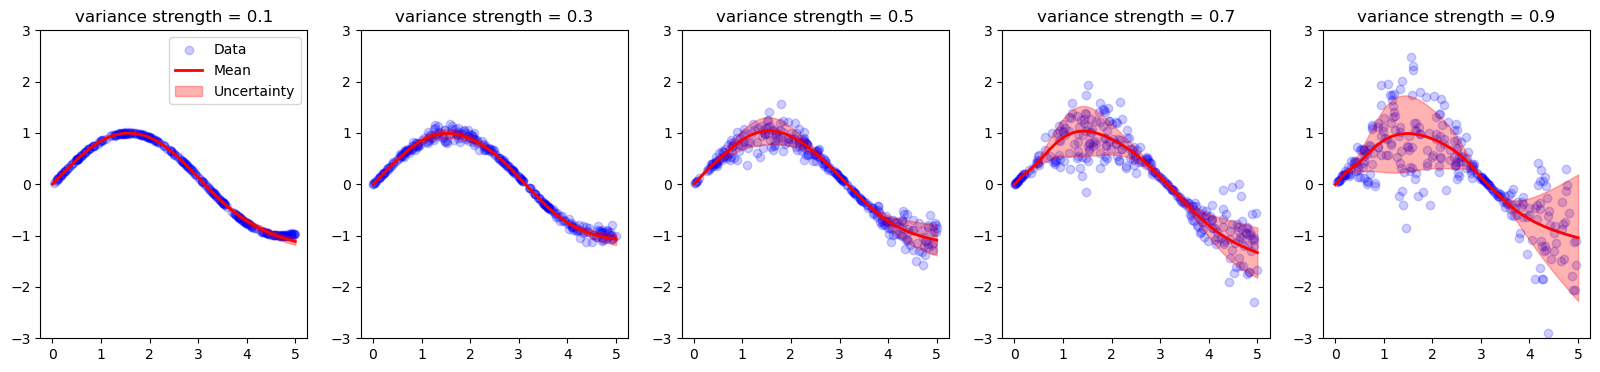

In [5]:
N_DATA = 300
VS = [0.1, 0.3, 0.5, 0.7, 0.9]
N_EPOCHS = 1000

plt.figure(figsize=(20, 4))
for idx, vs in enumerate(VS):
    print(f"training model {idx+1}/{len(VS)}", end="\r")
    X, y = make_mean_dependent_variance_data(N_DATA, variance_strength=vs) # generate data
    model = RegressionNetwork() # initialitze network
    model = train(model, X, y, N_EPOCHS) # train network

    with torch.no_grad():
        new_x = torch.linspace(0, 5, 100).view(-1, 1)
        mean, log_var = model(new_x) # predict from fitted model
    var = torch.exp(log_var) # model output is log variance! 
    
    # Plot mean and uncertainty of the predictions
    plt.subplot(1,len(VS), idx+1)
    plt.scatter(X, y, c='b', marker='o', label='Data', zorder=0, alpha=0.2)
    plt.plot(new_x, mean, 'r', lw=2, label='Mean')
    plt.fill_between(new_x.squeeze(), mean.squeeze() - torch.sqrt(var).squeeze(), mean.squeeze() + torch.sqrt(var).squeeze(), color='r', alpha=0.3, label='Uncertainty')
    plt.ylim(-3, 3)
    plt.title(f"variance strength = {vs}")
    if idx ==0:
        plt.legend()
plt.show()

### Location dependent variance

Generate a dataset where the varanice changes as a function of x

In [6]:
def make_location_dependent_variance_data(n, variance_intervalls = [[0,1], [2,3]], 
                                          variance_strengths=[0.3, 0.5], x_min=0, x_max=5):    
    '''
    Generate datapoints from a sinus function from x_min to x_max and add gaussian random 
    noise in with fixed variance in specified intervals.
    
    n .... number of samples to generate
    variance_intervalls ... intervals on the x-axis for which a non-zero variance is specified
    variance_strength ... factor by which to scale the variance per interval
    x_min, x_max ... start and end of the functions x-values
    '''
    
    X = np.sort((x_max-x_min)*np.random.rand(n, 1) + x_min, axis=0)
    y = np.sin(X).ravel()

    
    for idx, interval in enumerate(variance_intervalls):
        # iterate through specified intervals and add gaussian noise
        interval_idx = np.logical_and((X>interval[0]), (X<interval[1])).flatten()
        y[interval_idx] += np.random.normal(loc=0., scale=variance_strengths[idx], size=len(y[interval_idx]))
        
    # Convert data to PyTorch tensors
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()

    return X, y

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:17<00:00, 342.56it/s]


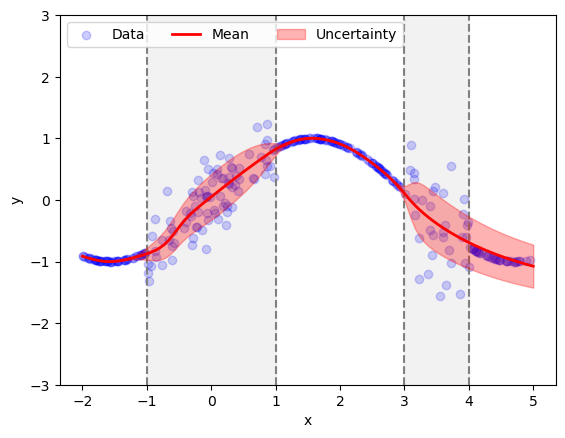

In [7]:
variance_intervalls = [[-1,1], [3,4]]
variance_strengths = [0.3, 0.6]
X_min = -2
X_max = 5
N_EPOCHS = 6000
N_DATA = 300

# generate data
X, y = make_location_dependent_variance_data(N_DATA, 
                                             variance_intervalls=variance_intervalls, 
                                             variance_strengths=variance_strengths, 
                                             x_min=X_min, x_max=X_max)
model = RegressionNetwork() # initialize model
model = train(model, X, y, N_EPOCHS) # train model

with torch.no_grad(): # predict from fitted model
    new_x = torch.linspace(X_min, X_max, 100).view(-1, 1)
    mean, log_var = model(new_x)
var = torch.exp(log_var)

plt.scatter(X, y, c='b', marker='o', label='Data', zorder=0, alpha=0.2)
for vi in variance_intervalls:
    # highlight areas of non-zero variance
    plt.axvline(x=vi[0], color="grey", linestyle="--", zorder=0)
    plt.axvline(x=vi[1], color="grey", linestyle="--", zorder=0)
    plt.fill_between(x=vi, y1=[-3, -3], y2=[3,3], color="grey", alpha=0.1)
plt.plot(new_x, mean, 'r', lw=2, label='Mean')
plt.fill_between(new_x.squeeze(), mean.squeeze() - torch.sqrt(var).squeeze(), mean.squeeze() + torch.sqrt(var).squeeze(), color='r', alpha=0.3, label='Uncertainty')
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(ncols=3)

plt.savefig("Predict_regression_heteroscedastic.png")
plt.show()

### Prediction on OOD data [outside of training interavl]

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:18<00:00, 319.48it/s]


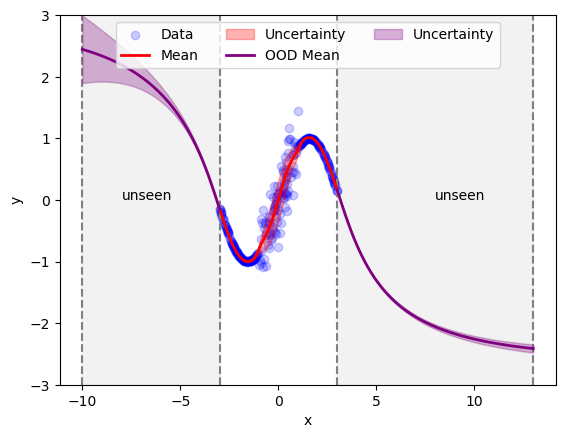

In [8]:
variance_intervalls = [[-1,1]]
variance_strengths = [0.3]
X_min = -3
X_max = 3
N_EPOCHS = 6000
N_DATA = 300

# generate data
X, y = make_location_dependent_variance_data(N_DATA, variance_intervalls=variance_intervalls, 
                                             variance_strengths=variance_strengths, 
                                             x_min=X_min, x_max=X_max)
model = RegressionNetwork() 
model = train(model, X, y, N_EPOCHS)

# predict on new data from training intervall
with torch.no_grad():
    new_x = torch.linspace(X_min, X_max, 100).view(-1, 1)
    mean, log_var = model(new_x)
    var = torch.exp(log_var)

plt.scatter(X, y, c='b', marker='o', label='Data', zorder=0, alpha=0.2)
plt.plot(new_x, mean, 'r', lw=2, label='Mean')
plt.fill_between(new_x.squeeze(), mean.squeeze() - torch.sqrt(var).squeeze(), mean.squeeze() + torch.sqrt(var).squeeze(), color='r', alpha=0.3, label='Uncertainty')


# predict on new data left of training intervall 
ood_min = -10
with torch.no_grad():
    ood_x = torch.linspace(ood_min, X_min, 100).view(-1, 1)
    ood_mean, ood_log_var = model(ood_x)
    ood_var = torch.exp(ood_log_var)
plt.plot(ood_x, ood_mean, 'purple', lw=2, label='OOD Mean')
plt.fill_between(ood_x.squeeze(), ood_mean.squeeze() - torch.sqrt(ood_var).squeeze(), ood_mean.squeeze() + torch.sqrt(ood_var).squeeze(), color='purple', alpha=0.3, label='Uncertainty')
plt.axvline(x=ood_min, color="grey", linestyle="--", zorder=0)
plt.axvline(x=X_min, color="grey", linestyle="--", zorder=0)
plt.fill_between(x=[ood_min, X_min], y1=[-3, -3], y2=[3,3], color="grey", alpha=0.1)
plt.text(x=-8, y=0, s="unseen")


# predict on new data right of training intervall 
ood_max = 13
with torch.no_grad():
    ood_x = torch.linspace(X_max, ood_max, 100).view(-1, 1)
    ood_mean, ood_log_var = model(ood_x)
    ood_var = torch.exp(ood_log_var)
plt.plot(ood_x, ood_mean, 'purple', lw=2)
plt.fill_between(ood_x.squeeze(), ood_mean.squeeze() - torch.sqrt(ood_var).squeeze(), ood_mean.squeeze() + torch.sqrt(ood_var).squeeze(), color='purple', alpha=0.3)
plt.axvline(x=X_max, color="grey", linestyle="--", zorder=0)
plt.axvline(x=ood_max, color="grey", linestyle="--", zorder=0)
plt.fill_between(x=[X_max, ood_max], y1=[-3, -3], y2=[3,3], color="grey", alpha=0.1)
plt.text(x=8, y=0, s="unseen")


plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-3, 3)
plt.legend(ncol=3, loc="upper center")
plt.savefig("Predict_regression_OOD_1.png")
plt.show()

### Prediction on OOD data [outside of training interavl]

#### Example 1


C:\Users\cwinklm\AppData\Local\Temp\ipykernel_17932\931675733.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = y[torch.tensor(np.logical_or((X<data_break[0]), (X>data_break[1])), dtype=torch.bool).squeeze()]
C:\Users\cwinklm\AppData\Local\Temp\ipykernel_17932\931675733.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = X[torch.tensor(np.logical_or((X<data_break[0]), (X>data_break[1])), dtype=torch.bool).squeeze()]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:16<00:00, 353.97it/s]


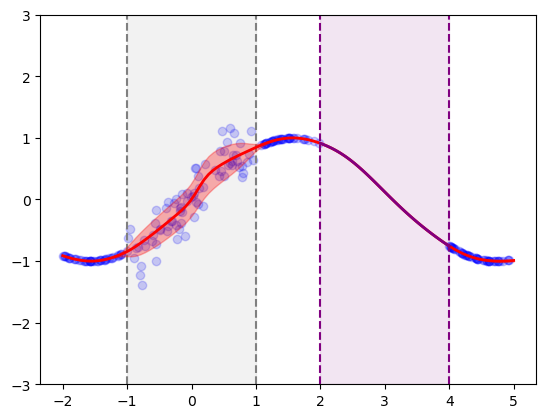

In [10]:
variance_intervalls = [[-1,1]]
variance_strengths = [0.3]
X_min = -2
X_max = 5
N_EPOCHS = 6000
N_DATA = 300

#generate data
X, y = make_location_dependent_variance_data(N_DATA, variance_intervalls=variance_intervalls, 
                                             variance_strengths=variance_strengths, 
                                             x_min=X_min, x_max=X_max)
data_break = [2, 4] # remove data of this interval from training
y = y[torch.tensor(np.logical_or((X<data_break[0]), (X>data_break[1])), dtype=torch.bool).squeeze()]
X = X[torch.tensor(np.logical_or((X<data_break[0]), (X>data_break[1])), dtype=torch.bool).squeeze()]

model = RegressionNetwork() # initilize network
model = train(model, X, y, N_EPOCHS) # train network
with torch.no_grad():
    # predict from fittet network
    new_x = torch.linspace(X_min, X_max, 100).view(-1, 1)
    mean, log_var = model(new_x)
    var = torch.exp(log_var)

    
plt.scatter(X, y, c='b', marker='o', label='Data', zorder=0, alpha=0.2)
for vi in variance_intervalls:
    plt.axvline(x=vi[0], color="grey", linestyle="--", zorder=0)
    plt.axvline(x=vi[1], color="grey", linestyle="--", zorder=0)
    plt.fill_between(x=vi, y1=[-3, -3], y2=[3,3], color="grey", alpha=0.1)
plt.plot(new_x, mean, 'r', lw=2, label='Mean')
plt.fill_between(new_x.squeeze(), mean.squeeze() - torch.sqrt(var).squeeze(), mean.squeeze() + torch.sqrt(var).squeeze(), color='r', alpha=0.3, label='Uncertainty')
plt.ylim(-3, 3)


with torch.no_grad():
    unseen_x = torch.linspace(data_break[0], data_break[1], 100).view(-1, 1)
    unseen_mean, unseen_log_var = model(unseen_x)
    unseen_var = torch.exp(unseen_log_var)
plt.axvline(x=data_break[0], color="purple", linestyle="--", zorder=0)
plt.axvline(x=data_break[1], color="purple", linestyle="--", zorder=0)
plt.fill_between(x=data_break, y1=[-3, -3], y2=[3,3], color="purple", alpha=0.1)
plt.plot(unseen_x, unseen_mean, 'purple', lw=2, label='Unseen Mean')
plt.fill_between(unseen_x.squeeze(), unseen_mean.squeeze() - torch.sqrt(unseen_var).squeeze(), unseen_mean.squeeze() + torch.sqrt(unseen_var).squeeze(), color='purple', alpha=0.3, label='Unseen Uncertainty')

plt.savefig("Predict_regression_OOD_2.png")
plt.show()

In [11]:
#### Example 2

C:\Users\cwinklm\AppData\Local\Temp\ipykernel_17932\1785345114.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\Users\arc\ruijie\RC3\py311\frameworks.ai.pytorch.private-gpu\aten\src\ATen/native/IndexingUtils.h:28.)
  y = y[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]
C:\Users\cwinklm\AppData\Local\Temp\ipykernel_17932\1785345114.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\Users\arc\ruijie\RC3\py311\frameworks.ai.pytorch.private-gpu\aten\src\ATen/native/IndexingUtils.h:28.)
  X = X[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 431.98it/s]


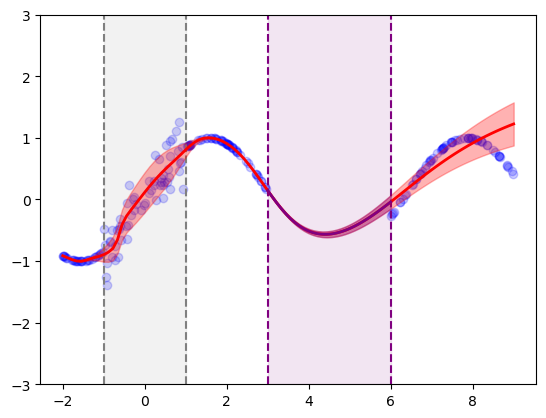

In [12]:
variance_intervalls = [[-1,1]]
variance_strengths = [0.3]
X_min = -2
X_max = 9
N_EPOCHS = 6000
N_DATA = 300
data_break = [3,6]

X, y = make_location_dependent_variance_data(N_DATA, variance_intervalls=variance_intervalls, variance_strengths=variance_strengths, x_min=X_min, x_max=X_max)
y = y[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]
X = X[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]

model = RegressionNetwork()
model = train(model, X, y, N_EPOCHS)

with torch.no_grad():
    new_x = torch.linspace(X_min, X_max, 100).view(-1, 1)
    mean, log_var = model(new_x)
    var = torch.exp(log_var)

plt.scatter(X, y, c='b', marker='o', label='Data', zorder=0, alpha=0.2)
for vi in variance_intervalls:
    plt.axvline(x=vi[0], color="grey", linestyle="--", zorder=0)
    plt.axvline(x=vi[1], color="grey", linestyle="--", zorder=0)
    plt.fill_between(x=vi, y1=[-3, -3], y2=[3,3], color="grey", alpha=0.1)
plt.plot(new_x, mean, 'r', lw=2, label='Mean')
plt.fill_between(new_x.squeeze(), mean.squeeze() - torch.sqrt(var).squeeze(), mean.squeeze() + torch.sqrt(var).squeeze(), color='r', alpha=0.3, label='Uncertainty')
plt.ylim(-3, 3)


with torch.no_grad():
    unseen_x = torch.linspace(data_break[0], data_break[1], 100).view(-1, 1)
    unseen_mean, unseen_log_var = model(unseen_x)
    unseen_var = torch.exp(unseen_log_var)
plt.axvline(x=data_break[0], color="purple", linestyle="--", zorder=0)
plt.axvline(x=data_break[1], color="purple", linestyle="--", zorder=0)
plt.fill_between(x=data_break, y1=[-3, -3], y2=[3,3], color="purple", alpha=0.1)
plt.plot(unseen_x, unseen_mean, 'purple', lw=2, label='Unseen Mean')
plt.fill_between(unseen_x.squeeze(), unseen_mean.squeeze() - torch.sqrt(unseen_var).squeeze(), unseen_mean.squeeze() + torch.sqrt(unseen_var).squeeze(), color='purple', alpha=0.3, label='Unseen Uncertainty')

plt.savefig("Predict_regression_OOD_3.png")
plt.show()

#### Example 3

C:\Users\cwinklm\AppData\Local\Temp\ipykernel_17932\171087907.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\Users\arc\ruijie\RC3\py311\frameworks.ai.pytorch.private-gpu\aten\src\ATen/native/IndexingUtils.h:28.)
  y = y[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]
C:\Users\cwinklm\AppData\Local\Temp\ipykernel_17932\171087907.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\Users\arc\ruijie\RC3\py311\frameworks.ai.pytorch.private-gpu\aten\src\ATen/native/IndexingUtils.h:28.)
  X = X[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:14<00:00, 409.52it/s]


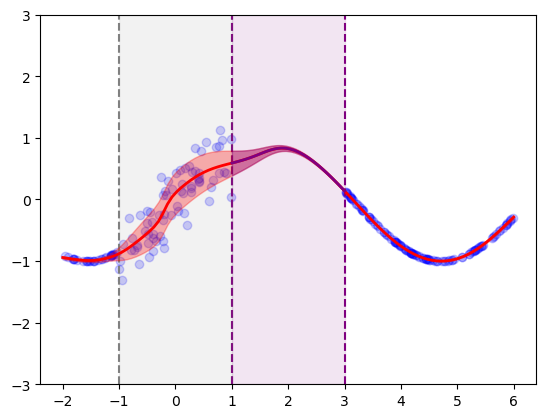

In [13]:
variance_intervalls = [[-1,1]]
variance_strengths = [0.3]
X_min = -2
X_max = 6
N_EPOCHS = 6000
N_DATA = 300
data_break = [1,3]

X, y = make_location_dependent_variance_data(N_DATA, variance_intervalls=variance_intervalls, variance_strengths=variance_strengths, x_min=X_min, x_max=X_max)
y = y[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]
X = X[np.logical_or((X<data_break[0]), (X>data_break[1])).flatten()]

model = RegressionNetwork()
model = train(model, X, y, N_EPOCHS)

with torch.no_grad():
    new_x = torch.linspace(X_min, X_max, 100).view(-1, 1)
    mean, log_var = model(new_x)
    var = torch.exp(log_var)

plt.scatter(X, y, c='b', marker='o', label='Data', zorder=0, alpha=0.2)
for vi in variance_intervalls:
  plt.axvline(x=vi[0], color="grey", linestyle="--", zorder=0)
  plt.axvline(x=vi[1], color="grey", linestyle="--", zorder=0)
  plt.fill_between(x=vi, y1=[-3, -3], y2=[3,3], color="grey", alpha=0.1)
plt.plot(new_x, mean, 'r', lw=2, label='Mean')
plt.fill_between(new_x.squeeze(), mean.squeeze() - torch.sqrt(var).squeeze(), mean.squeeze() + torch.sqrt(var).squeeze(), color='r', alpha=0.3, label='Uncertainty')
plt.ylim(-3, 3)


with torch.no_grad():
    unseen_x = torch.linspace(data_break[0], data_break[1], 100).view(-1, 1)
    unseen_mean, unseen_log_var = model(unseen_x)
    unseen_var = torch.exp(unseen_log_var)
plt.axvline(x=data_break[0], color="purple", linestyle="--", zorder=0)
plt.axvline(x=data_break[1], color="purple", linestyle="--", zorder=0)
plt.fill_between(x=data_break, y1=[-3, -3], y2=[3,3], color="purple", alpha=0.1)
plt.plot(unseen_x, unseen_mean, 'purple', lw=2, label='Unseen Mean')
plt.fill_between(unseen_x.squeeze(), unseen_mean.squeeze() - torch.sqrt(unseen_var).squeeze(), unseen_mean.squeeze() + torch.sqrt(unseen_var).squeeze(), color='purple', alpha=0.3, label='Unseen Uncertainty')

plt.savefig("Predict_regression_OOD_4.png")
plt.show()

In [14]:
##